In [1]:
import pandas as pd
df= pd.read_json('dblp-ref-0.json', lines=True)
#print(df)

In [2]:
df.dropna(subset = ["references"], inplace=True)
df.dropna(subset = ["abstract"], inplace=True)
df=df[df['references'].map(lambda d: len(d)) > 0]
df=df.reset_index(drop=True)

In [3]:
#To limit the number of input
data=df.head(10000)
#print(data)

In [4]:
#Collect important information
doc_list = list(data['id'].values)
year_list = list(data['year'].values)
ref_list = list(data['references'].values)
citation_list = list(data['n_citation'].values)
abstract_list = list(data['abstract'].values)
num_docs = len(doc_list)
#print(len(doc_list))

In [5]:
from top2vec import Top2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags

def bigrammer(doc):
    sentence_stream = simple_preprocess(strip_tags(doc), deacc=True)
    return bigram_phraser[sentence_stream]

sentence_stream = [doc.split(" ") for doc in  abstract_list]
bigram = Phrases(sentence_stream, min_count=5, threshold=100, delimiter=b' ')
bigram_phraser = Phraser(bigram)

model = Top2Vec(abstract_list,tokenizer=bigrammer,speed="deep-learn")
model.save("DBLP-T2V_MODEL-V11-0")

#print(model.get_num_topics())

2021-11-18 11:25:07,583 - top2vec - INFO - Pre-processing documents for training
2021-11-18 11:25:12,933 - top2vec - INFO - Creating joint document/word embedding
2021-11-18 11:36:09,513 - top2vec - INFO - Creating lower dimension embedding of documents
2021-11-18 11:36:34,065 - top2vec - INFO - Finding dense areas of documents
2021-11-18 11:36:34,445 - top2vec - INFO - Finding topics


In [6]:
#from top2vec import Top2Vec
#model = Top2Vec.load("DBLP-T2V_MODEL-V11-0")

#test: get topics of a document
#topic_nums,topic_score,topics_words,word_scores=model.get_documents_topics([0], reduced=False, num_topics=3)
#print(model.get_num_topics())

In [7]:
print(model.get_num_topics())

87


In [8]:
# Make the raw citation network by networkx
import networkx as nx
G = nx.DiGraph()
for i in range(num_docs):
    topic_nums,topic_score,topics_words,word_scores=model.get_documents_topics([i], reduced=False, num_topics=3)
    G.add_node(doc_list[i],citation=citation_list[i],topics=topic_nums.tolist())
    for j in range(len(ref_list[i])):
        G.add_node(ref_list[i][j])
        G.add_edge(ref_list[i][j],doc_list[i])
print(nx.info(G))

DiGraph with 80518 nodes and 93553 edges


In [9]:
def graph_cleaner(graph,attribute):
    r=nx.DiGraph.to_undirected(graph)
    node_list=[]
    v= nx.get_node_attributes(r,attribute)
    for node in r.nodes:
        if node not in v:
            node_list.append(node)
    graph.remove_nodes_from(node_list)

T=G.copy()
print("before graph processing:",nx.info(T))
graph_cleaner(T,"topics")
print("after cleaning useless nodes:",nx.info(T))
remove = [node for node, degree in dict(T.degree()).items() if degree ==0]
T.remove_nodes_from(remove)
print("after removing single nodes:",nx.info(T))


before graph processing: DiGraph with 80518 nodes and 93553 edges
after cleaning useless nodes: DiGraph with 10000 nodes and 536 edges
after removing single nodes: DiGraph with 905 nodes and 536 edges


In [10]:
#functions for calculating the impact influenced by https://link.springer.com/content/pdf/10.1007/s11192-021-04063-1.pdf

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

## p2 cited p1, and p1 influenced p2
def paper_citation_relation(g,p1,p2,f1,f2,c1,c2):
    if g.has_edge(p1,p2) and (c1+c2)!=0:
       return (c1/(c1+c2))+jaccard_similarity(f1, f2)
    else: return 0
#f1 is the list of keywords of paper p1
def keyword_citation_relation_raw(fi,fj,f1,f2):
    # if order is important
    #return 1/((f1.index(fi)+1)*(1+f2.index(fj)))
    #if not
    return 1
def keyword_citation_relation_pre(g,p1,p2,f1,f2,c1,c2,fi,fj):
    w_pp=paper_citation_relation(g,p1,p2,f1,f2,c1,c2)
    w_ca_raw=keyword_citation_relation_raw(fi,fj,f1,f2)
    sum=0
    for i in f1:
        for j in f2:
            sum=sum+keyword_citation_relation_raw(i,j,f1,f2)
    return w_pp* w_ca_raw/sum

def keyword_citation_relation(g,fi,fj):
    influence=0
    k=nx.get_node_attributes(g,"topics")
    c=nx.get_node_attributes(g,"citation")
    if fi != fj:
        for node in g.nodes:
            if fi in k[node][0]:
                c1=c[node]
                f1=k[node][0]
                for neighbor in g.neighbors(node):
                    if fj in k[neighbor][0]:
                        c2=c[neighbor]
                        f2=k[neighbor][0]
                        influence=influence+keyword_citation_relation_pre(g,node,neighbor,f1,f2,c1,c2,fi,fj)
        return influence
    else: return 1

#Test the result
#print(keyword_citation_relation(T,3,5))

In [11]:
import numpy as np

def nest_list(list1,rows, columns):
        result=[]
        start = 0
        end = columns
        for i in range(rows):
            result.append(list1[start:end])
            start +=columns
            end += columns
        return result

topic_inf_adj=[]
for topic_i in range(model.get_num_topics()):
    for topic_j in range(model.get_num_topics()):
        #print(topic_i,topic_j)
        topic_inf_adj.append(keyword_citation_relation(T,topic_i,topic_j))

adj_matrix=nest_list(topic_inf_adj,78,78)
adj_matrix = np.array(adj_matrix)

Topic-Impact Graph info: DiGraph with 78 nodes and 2239 edges


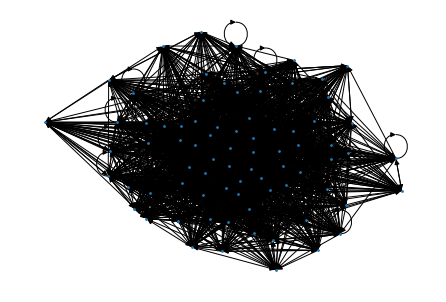

In [12]:
TIG=nx.from_numpy_matrix(adj_matrix, parallel_edges=False, create_using=nx.DiGraph)

print("Topic-Impact Graph info:",nx.info(TIG))

nx.draw(TIG,node_size=3)

Cleaned Topic-Impact Graph info: DiGraph with 78 nodes and 1802 edges


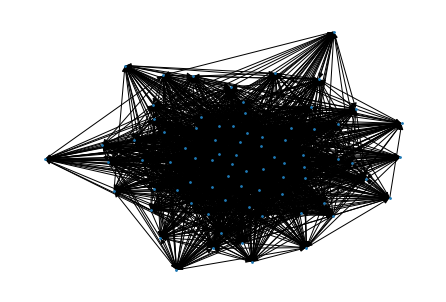

In [13]:
def topic_cleaner(topic_impact_graph,citation_graph):
    rc=nx.DiGraph.to_undirected(topic_impact_graph)
    for node in rc.nodes:
        for neighbor in rc.neighbors(node):
            ab=keyword_citation_relation(citation_graph,node,neighbor)
            ba=keyword_citation_relation(citation_graph,neighbor,node)
            if topic_impact_graph.has_edge(node, neighbor) and topic_impact_graph.has_edge(neighbor, node):
                if ab>=ba:
                    topic_impact_graph.remove_edge(neighbor, node)
                else:
                    topic_impact_graph.remove_edge(node, neighbor)
    return topic_impact_graph

TIG=topic_cleaner(TIG,T)
print("Cleaned Topic-Impact Graph info:",nx.info(TIG))
nx.draw(TIG,node_size=3)

filtered Topic-Impact Graph info: DiGraph with 77 nodes and 127 edges


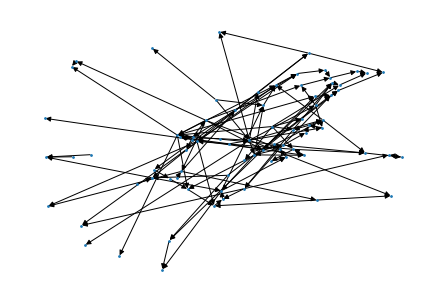

In [14]:
def impact_filter(topic_impact_graph,filter_value):
    rc=topic_impact_graph.copy()
    for (a,b) in rc.edges:
        if (rc.get_edge_data(a, b, default=None)['weight'])<filter_value:
            topic_impact_graph.remove_edge(a, b)
    remove = [node for node, degree in dict(topic_impact_graph.degree()).items() if degree ==0]
    topic_impact_graph.remove_nodes_from(remove)
    return topic_impact_graph

F_TIG=impact_filter(TIG,0.5)
print("filtered Topic-Impact Graph info:",nx.info(F_TIG))
nx.draw(F_TIG,node_size=3)

[2011, 1999, 2007, 2010, 2012, 2013, 2014, 2011, 2007, 1996, 2012, 2013, 2013, 2011, 2014, 2012, 2013, 2010, 2011, 2007, 2012, 2006, 2011, 2010, 2011, 2003, 2011, 2013, 2012, 2006, 2012, 2011, 2012, 2012, 2012, 2012, 2013, 2012, 2011, 2004, 2013, 2012, 2011, 1982, 2011, 2012, 2011, 2012, 2011, 2013, 2009, 2012, 2013, 2007, 2011, 2010, 2011, 2012, 2011, 2007, 2013, 2012, 2007, 1987, 2011, 2013, 2012, 2013, 2013, 2007, 2015, 2011, 2013, 2012, 2001, 2013, 2012, 2012, 2012, 2011, 2012, 2011, 2011, 2012, 2014, 2014, 2012, 2011, 2012, 2007, 2013, 2012, 2011, 2014, 2013, 2013, 2012, 2014, 2005, 2013, 2012, 2002, 2013, 2005, 2012, 2011, 2010, 2011, 2012, 2011, 2012, 2012, 2011, 2012, 2008, 2014, 2012, 2012, 2013, 2011, 2006, 2011, 2011, 2012, 2014, 2012, 2010, 2012, 2013, 2016, 2011, 2003, 2002, 2008, 2008, 2012, 1993, 1997, 1998, 2014, 2011, 2014, 2006, 2010, 2011, 2010, 2014, 2012, 2012, 2012, 2011, 1996, 2014, 2014, 2011, 2014, 2011, 2011, 2013, 2012, 2010, 1999, 2003, 2011, 2014, 2003, 201

/Users/hamed/Documents/PhD/Documents2EvolutionGraph/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


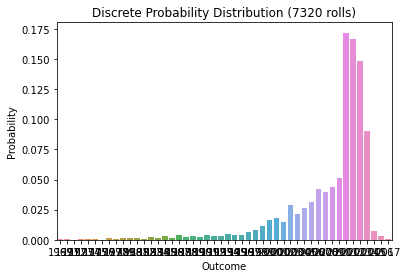

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
time_distribution=[[]] * (F_TIG.number_of_nodes()+1)
for topic in F_TIG.nodes:
    try:
        documents, doc_scores, doc_ids=model.search_documents_by_topic(topic,
                                                                   round(num_docs/F_TIG.number_of_nodes()),
                                                                       return_documents=True, reduced=False)
    except ValueError as e:
        documents, doc_scores, doc_ids=model.search_documents_by_topic(topic,
                                                                   [int(s) for s in str(e).split() if s.isdigit()][1],
                                                                    return_documents=True, reduced=False)
    for id in doc_ids:
            time_distribution[topic].append(year_list[id])


topic_id_for_plot=time_distribution[45]
side, count = np.unique(topic_id_for_plot, return_counts=True)
probs = count / len(topic_id_for_plot)

# Plot the results
sns.barplot(side, probs)
plt.title(
    f"Discrete Probability Distribution ({len(topic_id_for_plot)} rolls)")
plt.ylabel("Probability")
plt.xlabel("Outcome")
plt.show()

2008.2779743242997


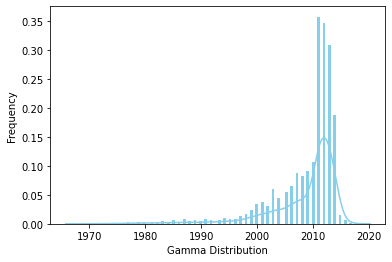

In [65]:
import scipy
from scipy.stats import gamma

#Gamma Distribution
ax = sns.distplot(topic_id_for_plot,
                  kde=True,
                  bins=100,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Gamma Distribution', ylabel='Frequency')

params = scipy.stats.gamma.fit(topic_id_for_plot)
print(scipy.stats.gamma.mean(*params))


[Text(0.5, 0, 'Poisson Distribution'), Text(0, 0.5, 'Frequency')]

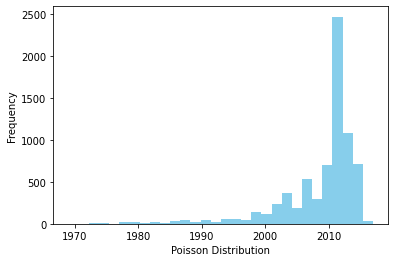

In [64]:
#Poisson Distribution
ax = sns.distplot(topic_id_for_plot,
                  bins=30,
                  kde=False,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Poisson Distribution', ylabel='Frequency')
